In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.plots as mpplots
import numpy as np
from matplotlib.patheffects import withStroke
from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays
from siphon.catalog import TDSCatalog

In [2]:
satcat = TDSCatalog(
    "https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/current/catalog.xml"
)
satdata = satcat.datasets[0].remote_access(use_xarray=True)

In [3]:
cmi = satdata.metpy.parse_cf("Sectorized_CMI")
dt = datetime.strptime(satdata.attrs["start_date_time"], "%Y%j%H%M%S")

In [4]:
rtma_cat = TDSCatalog(
    "https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml"
)
rtma_data = rtma_cat.datasets["Full Collection Dataset"].remote_access(use_xarray=True)
rtma_data = rtma_data.metpy.parse_cf()

In [5]:
pres = rtma_data.Pressure_Analysis_surface.metpy.sel(
    time=dt, method="nearest"
).squeeze()
temp = rtma_data.Temperature_Analysis_height_above_ground.metpy.sel(
    time=dt, method="nearest"
).squeeze()
dewp = rtma_data.Dewpoint_temperature_Analysis_height_above_ground.metpy.sel(
    time=dt, method="nearest"
).squeeze()
theta_e = mpcalc.equivalent_potential_temperature(pres, temp, dewp)

In [6]:
theta_e = mpcalc.smooth_gaussian(theta_e, n=50)

In [7]:
rtma_crs = theta_e.metpy.cartopy_crs

In [8]:
metar_cat = TDSCatalog(
    "https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml"
)
metar_text = metar_cat.datasets.filter_time_nearest(dt).remote_open(mode="t")

sfc_data = parse_metar_file(metar_text, year=dt.year, month=dt.month)

sfc_units = sfc_data.units

sfc_data = pandas_dataframe_to_unit_arrays(sfc_data, sfc_units)

In [9]:
locs = rtma_crs.transform_points(
    ccrs.PlateCarree(), sfc_data["longitude"].m, sfc_data["latitude"].m
)

plot_mask = mpcalc.reduce_point_density(
    locs[..., :2], 175000, priority=sfc_data["current_wx1_symbol"]
)

Text(0.5, 1.0, 'GOES-16 Ch. 2, RTMA $\\theta_e$, Surface Obs at 20220228T1651')

/Users/drewcamron/mambaforge/envs/support/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


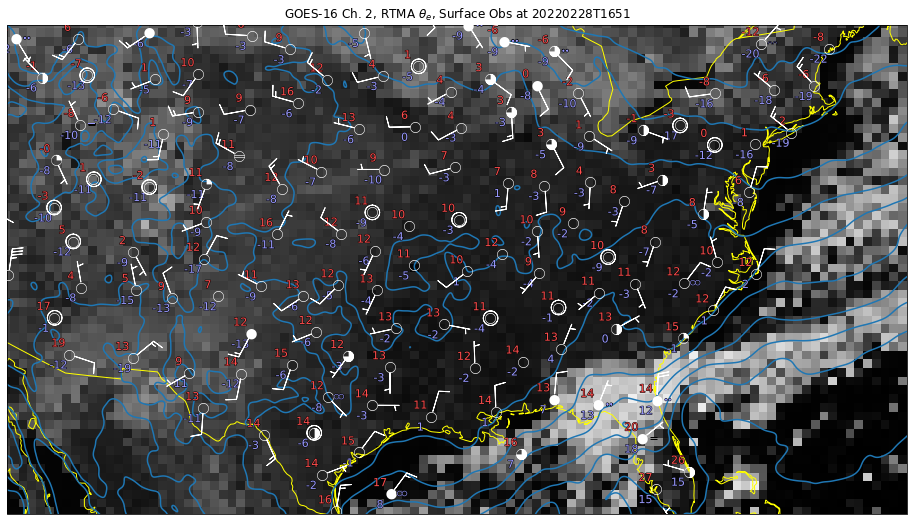

In [10]:
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(projection=rtma_crs)

image_extent = (cmi.metpy.x[0], cmi.metpy.x[-1], cmi.metpy.y[0], cmi.metpy.y[-1])
ax.imshow(
    cmi,
    extent=image_extent,
    origin="lower",
    cmap="Greys_r",
    regrid_shape=500,
    transform=cmi.metpy.cartopy_crs,
)

ax.contour(
    theta_e.metpy.x,
    theta_e.metpy.y,
    theta_e,
    levels=range(240, 400, 8),
    colors="tab:blue",
    transform=theta_e.metpy.cartopy_crs,
)

stn = mpplots.StationPlot(
    ax,
    sfc_data["longitude"][plot_mask].m,
    sfc_data["latitude"][plot_mask].m,
    transform=ccrs.PlateCarree(),
    fontsize=11,
    zorder=10,
    clip_on=True,
)
stn.plot_parameter(
    "NW",
    sfc_data["air_temperature"][plot_mask],
    color=[1.0, 0.3, 0.3],
    path_effects=[withStroke(linewidth=1, foreground="black")],
)
stn.plot_parameter(
    "SW",
    sfc_data["dew_point_temperature"][plot_mask],
    color=[0.6, 0.6, 1.0],
    path_effects=[withStroke(linewidth=1, foreground="black")],
)
stn.plot_symbol(
    "C", sfc_data["cloud_coverage"][plot_mask], mpplots.sky_cover, color="white"
)
stn.plot_symbol(
    "E",
    sfc_data["current_wx1_symbol"][plot_mask],
    mpplots.current_weather,
    color=[0.6, 0.6, 1.0],
    path_effects=[withStroke(linewidth=1, foreground="black")],
)
stn.plot_barb(
    sfc_data["eastward_wind"][plot_mask],
    sfc_data["northward_wind"][plot_mask],
    color="white",
)

ax.add_feature(cfeature.BORDERS, color="yellow")
ax.add_feature(cfeature.COASTLINE, color="yellow")
ax.set_extent((-113, -70, 25, 45))

#### draft of caption
Map of the continental U.S. with background GOES-16 Channel 02 imagery, overlayed with contours of potential temperature calculated from Real-Time Mesoscale Analysis (RTMA) output and station models of surface observations from a collection of surface observation METARs. All products valid {date of production}.